# Now we will preprocess the cleaned data for our model
## 1-import important modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ipaddress
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Set display options as in the first code to show all columns whitout having to specify it always
pd.set_option('display.max_columns', None)

## 2-Loading cleaned Dataset

In [3]:
# Read the dataset
data_df = pd.read_csv("../../data/interim/conn_log_labeled-cleaned.csv", index_col=0)

### Check if every thing is ok

In [4]:
data_df.shape

(23145, 15)

In [5]:
data_df.head()

,id.orig_p,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,41040,80,tcp,NaN,3.139211,0.0,0.0,S0,0,S,3,180,0,0,Benign
1,41040,80,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,Benign
2,41040,80,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,Benign
3,41040,80,tcp,http,1.477656,149.0,128252.0,SF,2896,ShADadttcfF,94,5525,96,139044,Benign
4,41042,80,tcp,NaN,3.147116,0.0,0.0,S0,0,S,3,180,0,0,Benign


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23145 entries, 0 to 23144
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id.orig_p      23145 non-null  int64  
 1   id.resp_p      23145 non-null  int64  
 2   proto          23145 non-null  object 
 3   service        1847 non-null   object 
 4   duration       5321 non-null   float64
 5   orig_bytes     5321 non-null   float64
 6   resp_bytes     5321 non-null   float64
 7   conn_state     23145 non-null  object 
 8   missed_bytes   23145 non-null  int64  
 9   history        23145 non-null  object 
 10  orig_pkts      23145 non-null  int64  
 11  orig_ip_bytes  23145 non-null  int64  
 12  resp_pkts      23145 non-null  int64  
 13  resp_ip_bytes  23145 non-null  int64  
 14  label          23145 non-null  object 
dtypes: float64(3), int64(7), object(5)
memory usage: 2.8+ MB


## 3-Data Preprocessing
### Analyzing target attribute

In [7]:
# Check null values in the column "label"
data_df["label"].isna().sum()

np.int64(0)

So here every log is label which is good otherwise we would've delet logs without labels since they won't help us train the model

In [8]:
data_df["label"].value_counts()

label
Malicious    21222
Benign        1923
Name: count, dtype: int64

Now we are sure that there is no other value then malicious/benign as a label . So there is nothing to do here otherwise we would've delet them

<Axes: xlabel='label', ylabel='count'>

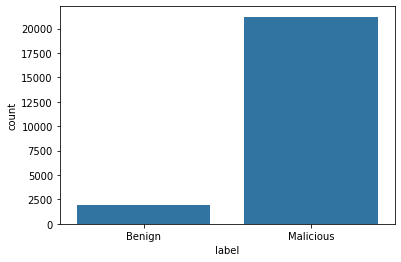

In [9]:
# Plot target attribute on a count plot
sns.countplot(data=data_df, x="label")

### Problem :
- Here we notice a huge difference between how many mal/ben logs we have , won't  this affect our training in a bad way?

### Encoding target attribute
We don't use string labels to train our model , therefor we must use a bijective function that associate to each label an int and we work with ints which is much better

In [10]:
# Initialize encoder with default parameters
target_le = LabelEncoder()
# Fit the encoder to the target attribute
encoded_attribute = target_le.fit_transform(data_df["label"])
# Replace target attribute with encoded values
data_df["label"] = encoded_attribute
# Check mapped labels
dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))

{'Benign': np.int64(0), 'Malicious': np.int64(1)}

In [11]:
data_df.head()

,id.orig_p,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,41040,80,tcp,NaN,3.139211,0.0,0.0,S0,0,S,3,180,0,0,0
1,41040,80,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,0
2,41040,80,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,0
3,41040,80,tcp,http,1.477656,149.0,128252.0,SF,2896,ShADadttcfF,94,5525,96,139044,0
4,41042,80,tcp,NaN,3.147116,0.0,0.0,S0,0,S,3,180,0,0,0


See ! here the labels are either 0 or 1 now .
### Now let's have some statistics

In [12]:
# Use describe() method to obtain general statistics about the numerical features
numerical_features = ["duration", "orig_bytes",	"resp_bytes", "missed_bytes", "orig_pkts",	"orig_ip_bytes", "resp_pkts", "resp_ip_bytes"]
data_df[numerical_features].describe()

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,5321.000000,5.321000e+03,5321.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000
mean,22.806503,1.478868e+04,350.429431,2.127112,6.375157,3.664312e+03,0.611017,111.218967
std,722.522302,1.036441e+06,5378.262771,102.490787,178.548725,5.003762e+05,8.305898,2713.082822
min,0.000497,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2.075814,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,3.110974,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,3.153695,6.200000e+01,243.000000,0.000000,1.000000,7.600000e+01,0.000000,0.000000
max,48976.819063,7.554662e+07,164266.000000,5792.000000,18444.000000,7.606306e+07,1070.000000,168910.000000


- In a quick reading of the statistical summary, we noticed many features with values that can be seen as outliers. 
- It's fairly difficult to confirm such values and their actual reasons without proper explanations by experts in the corresponding domain.
- For the sake of this demo, we will treat only "duration" as a feature with actual outliers as it's the only feature with a significant amount of unique values.

<Axes: ylabel='duration'>

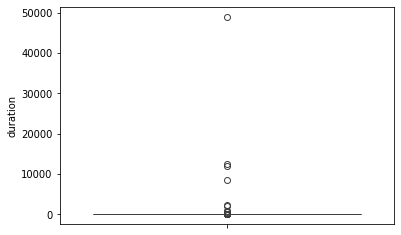

In [13]:
# Plot "duration" feature on a boxplot
sns.boxplot(data=data_df, y="duration")

In [14]:
data_df.head()

,id.orig_p,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,41040,80,tcp,NaN,3.139211,0.0,0.0,S0,0,S,3,180,0,0,0
1,41040,80,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,0
2,41040,80,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,0
3,41040,80,tcp,http,1.477656,149.0,128252.0,SF,2896,ShADadttcfF,94,5525,96,139044,0
4,41042,80,tcp,NaN,3.147116,0.0,0.0,S0,0,S,3,180,0,0,0


- we notice some extreme values which can represent some noise specialy the one at level 50000.

Let's try to visualise the distribution of this attribute

In [15]:
# I will write it in a general way so that if i must change the code to make more changes it will be easy just add new columns to the first list bellow
# Replace outliers using IQR (Inter-quartile Range)
outliers_columns = ['duration']
for col_name in outliers_columns:
    # Calculate first and third quartiles
    q1, q3 = np.nanpercentile(data_df[col_name],[25,75])
    print(q1,q3)
    # Calculate the inter-quartile range
    intr_qr = q3-q1
    print(intr_qr)
    # Calculate lower and higher bounds
    iqr_min_val = q1-(1.5*intr_qr)
    iqr_max_val = q3+(1.5*intr_qr)
    print(f"(min,max) bounds for \"{col_name}\": ({iqr_min_val},{iqr_max_val})")
    # Replace values that are less than min or larger then max with np.nan
    data_df.loc[data_df[col_name] < iqr_min_val, col_name] = np.nan
    data_df.loc[data_df[col_name] > iqr_max_val, col_name] = np.nan

2.075814 3.153695
1.077881
(min,max) bounds for "duration": (0.4589924999999997,4.7705165)


#### Why replacing those fields with null instead of removing the whole row (log) if its duration is considered as noise ? 
- Logs often contain valuable contextual information spread across multiple fields. Removing entire logs due to outliers in a single field could result in the loss of useful data from other fields.
- values can be imputed (filled in) later using various methods such as mean, median, mode, or more sophisticated algorithms like K-Nearest Neighbors (KNN) or regression models.
- You can decide to delete rows or columns with too many missing values at a later stage, based on a more comprehensive analysis of the missing data patterns.
- **Bias Reduction**: Deleting rows with outliers might introduce bias, especially if the outliers are not randomly distributed. For example, if outliers are more frequent in certain time periods or under specific conditions, deleting them could skew the dataset and affect the analysis.
- and maybe duration is not that important for our training compared to other fields , so we must not delete the whole row just because of it .

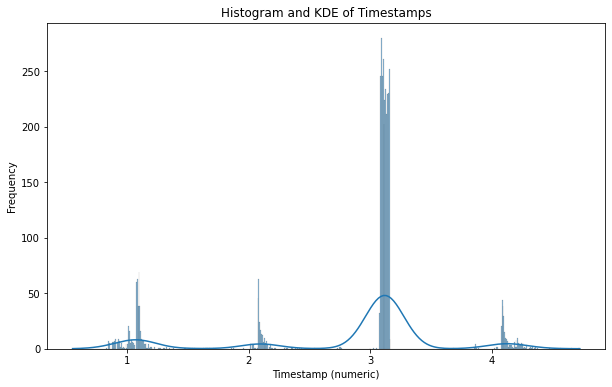

count    3718.000000
mean        2.848130
std         0.806614
min         0.553685
25%         3.085004
50%         3.110717
75%         3.140398
max         4.723553
Name: duration, dtype: float64

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(data_df['duration'], kde=True)
plt.title('Histogram and KDE of Timestamps')
plt.xlabel('Timestamp (numeric)')
plt.ylabel('Frequency')
plt.show()
# Reevaluate the new distribution of values
data_df["duration"].describe()

#### Handling missing values

In [17]:
# Check the number of null values in each column
data_df.isnull().sum().sort_values(ascending=False)

service          21298
duration         19427
orig_bytes       17824
resp_bytes       17824
proto                0
id.orig_p            0
id.resp_p            0
conn_state           0
missed_bytes         0
history              0
orig_pkts            0
orig_ip_bytes        0
resp_pkts            0
resp_ip_bytes        0
label                0
dtype: int64

<Axes: >

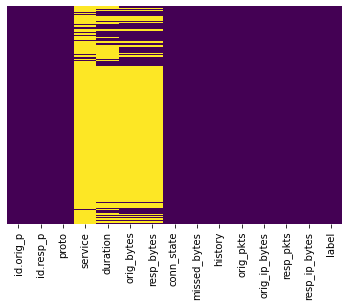

In [18]:
# Check null values using heatmap
sns.heatmap(data=data_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

- There are only 4 columns with a lot of missing values, one categorical ("service) and three numerical ("duration", "orig_bytes", "resp_bytes").
- One possible approach is to entirely discard these columns from the dataset. 
- Instead, we will try to impute their values to preserve any hidden information and check if we can obtain better prediction performance.
#### Impute missing values: categorical features

<Axes: xlabel='label', ylabel='count'>

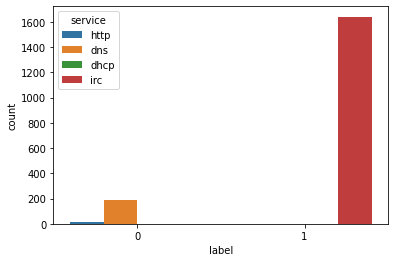

In [19]:
# Check the relationship between the "service" and the target attribute
sns.countplot(data=data_df, x="label", hue="service")

- Due to this visualization, almost all *Malicious* observations belong to a specific service type ("irc"), while the other 3 types represent *Benign* samples.
- Accordingly, although "service" feature has high number of missing values, it has a strong correlation with the target attribute.
- The decision here is to keep "service" attribute while trying to impute its missing values using another classifier. 

In [20]:
# we initially select the numerical attributes with no missing values.
srv_training_columns = ["id.orig_p","id.resp_p","missed_bytes","orig_pkts","orig_ip_bytes","resp_pkts","resp_ip_bytes"] 
# Split the rows into two datasets containing rows with/without "service"
data_df_with_service = data_df[data_df["service"].notna()]
data_df_no_service = data_df[data_df["service"].isna()]
#print(data_df_with_service)
# Split the service dataset into dependent and independent features
srv_X = data_df_with_service[srv_training_columns]
srv_y = data_df_with_service["service"].values
# Split into train/test subsets
srv_X_train, srv_X_test, srv_y_train, srv_y_test = train_test_split(srv_X, srv_y, test_size=0.2, random_state=0)
# KNN estimator
srv_knn = KNeighborsClassifier(n_neighbors=3)
'''When dealing with binary classification problems, using an odd number of neighbors (like 3) can help avoid ties.'''
srv_knn.fit(srv_X_train, srv_y_train)

# Predict missing values
srv_y_pred = srv_knn.predict(srv_X_test)
# accuracy
srv_accuracy_test = accuracy_score(srv_y_test, srv_y_pred)
print(f"Prediction accuracy for 'service' is: {srv_accuracy_test}")
print("Classification report:")
print(classification_report(srv_y_test, srv_y_pred))

Prediction accuracy for 'service' is: 1.0
Classification report:
              precision    recall  f1-score   support

         dns       1.00      1.00      1.00        41
        http       1.00      1.00      1.00         5
         irc       1.00      1.00      1.00       324

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



The classification model achieved an accuracy of 100%, which means all samples in the test subset were correctly predicted. Now we can use this model to predict missing "service" fields.

##### Leeeeeeeeeeeets gooooo the accuracy is 100% , Now we can use this model to predict missing "service" fields. :D 

In [21]:
srv_predictions = srv_knn.predict(data_df_no_service[srv_training_columns])
# Update the original data set with predicted "service" values
data_df.loc[data_df["service"].isna(), "service"] = srv_predictions

In [22]:
# To preserve hidden correlations with other features in the dataset, we will use a KNN imputer to estimate the missing values based on relationships with other numerical features.
numerical_features = data_df.drop("label", axis=1).select_dtypes(include="number").columns
knn_imputer = KNNImputer()
data_df_after_imputing = knn_imputer.fit_transform(data_df[numerical_features])

In [23]:
# Update original data set to fill missing values with imputed ones
data_df[numerical_features] = data_df_after_imputing
# Confirm all missing values were successfully imputed
data_df.isnull().sum().sort_values(ascending=False)

id.orig_p        0
id.resp_p        0
proto            0
service          0
duration         0
orig_bytes       0
resp_bytes       0
conn_state       0
missed_bytes     0
history          0
orig_pkts        0
orig_ip_bytes    0
resp_pkts        0
resp_ip_bytes    0
label            0
dtype: int64

### Scaling numerical attributes
- In case we want to try several classifiers,maybe some of them rely on distance-based comparisons, we will scale the numerical features to have them represented in a unified distribution.
- Since most attributes have no normal distribution, it's more suitable to apply a normalization (between 0 and 1, using MinMaxScaler) instead of standardization.

In [24]:
# Check statistics for numerical features
numerical_features = ["id.orig_p", "id.resp_p", "duration", "orig_bytes", "resp_bytes", "missed_bytes", "orig_pkts", "orig_ip_bytes",	"resp_pkts", "resp_ip_bytes"]
data_df[numerical_features].describe()

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,23145.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000
mean,56409.651847,2324.573558,3.019661,3.435934e+03,87.489721,2.127112,6.375157,3.664312e+03,0.611017,111.218967
std,17176.590987,5362.933817,0.362171,4.969529e+05,2582.581881,102.490787,178.548725,5.003762e+05,8.305898,2713.082822
min,0.000000,1.000000,0.553685,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,53622.000000,80.000000,3.093835,4.800000e+01,7.800000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,65279.000000,80.000000,3.093835,5.460000e+01,7.800000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,65279.000000,6667.000000,3.093835,5.460000e+01,7.800000,0.000000,1.000000,7.600000e+01,0.000000,0.000000
max,65279.000000,63798.000000,4.723553,7.554662e+07,164266.000000,5792.000000,18444.000000,7.606306e+07,1070.000000,168910.000000


#### On fait une normalisation des données

In [25]:
min_max_scaler = MinMaxScaler()
data_df[numerical_features] = min_max_scaler.fit_transform(data_df[numerical_features])


In [26]:
data_df[numerical_features].describe()

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,23145.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000
mean,0.864132,0.036421,0.591380,4.548098e-05,0.000533,0.000367,0.000346,4.817466e-05,0.000571,0.000658
std,0.263126,0.084062,0.086854,6.578095e-03,0.015722,0.017695,0.009681,6.578439e-03,0.007763,0.016062
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.821428,0.001238,0.609168,6.353692e-07,0.000047,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,1.000000,0.001238,0.609168,7.227325e-07,0.000047,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,1.000000,0.104488,0.609168,7.227325e-07,0.000047,0.000000,0.000054,9.991710e-07,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000


In [27]:
data_df.head()

,id.orig_p,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,0.628686,0.001238,tcp,dns,0.620050,0.000000e+00,0.000000,S0,0.0,S,0.000163,2.366458e-06,0.00000,0.000000,0
1,0.628686,0.001238,tcp,dns,0.620022,3.097425e-07,0.000047,S0,0.0,S,0.000054,7.888192e-07,0.00000,0.000000,0
2,0.628686,0.001238,tcp,dns,0.620022,3.097425e-07,0.000047,S0,0.0,S,0.000054,7.888192e-07,0.00000,0.000000,0
3,0.628686,0.001238,tcp,http,0.221583,1.972292e-06,0.780758,SF,0.5,ShADadttcfF,0.005097,7.263710e-05,0.08972,0.823184,0
4,0.628717,0.001238,tcp,dns,0.621946,0.000000e+00,0.000000,S0,0.0,S,0.000163,2.366458e-06,0.00000,0.000000,0


In [28]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23145 entries, 0 to 23144
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id.orig_p      23145 non-null  float64
 1   id.resp_p      23145 non-null  float64
 2   proto          23145 non-null  object 
 3   service        23145 non-null  object 
 4   duration       23145 non-null  float64
 5   orig_bytes     23145 non-null  float64
 6   resp_bytes     23145 non-null  float64
 7   conn_state     23145 non-null  object 
 8   missed_bytes   23145 non-null  float64
 9   history        23145 non-null  object 
 10  orig_pkts      23145 non-null  float64
 11  orig_ip_bytes  23145 non-null  float64
 12  resp_pkts      23145 non-null  float64
 13  resp_ip_bytes  23145 non-null  float64
 14  label          23145 non-null  int64  
dtypes: float64(10), int64(1), object(4)
memory usage: 2.8+ MB


- All categorical features(groups like colors) can be encoded using One-Hot Encoding because theydon't imply an ordered relationship between their values.
- We need first to check features with rare values (their frequency is small) and map them to "other", in order to avoid sparse columns with statistically negligible impact and higher computational effect.
#### explanation:
**One-Hot Encoding**: This technique converts categorical features into a numerical format suitable for machine learning algorithms ,for example : 
- One-hot encoding creates a binary vector (a vector with only 0s and 1s) for each categorical value. For example, if we have a categorical variable with three values (“Male”, “Female”, and “Other”), one-hot encoding would create three binary vectors:

    - For “Male”, the vector would be [1, 0, 0]
    - For “Female”, the vector would be [0, 1, 0]
    - For “Other”, the vector would be [0, 0, 1]
    
**Sparsity**: One-hot encoding features with many rare categories can result in numerous columns with very few '1's, leading to higher computational cost and potential reduction in model performance.

**Statistical Significance**: Grouping rare categories into "other" helps in reducing noise and computational overhead, ensuring more meaningful statistical analysis.

In [29]:
# Check the number of unique values in each feature
categorical_features = ["proto","service","conn_state","history"]
for c in categorical_features:
    print(f"Column ({c}) has ({data_df[c].nunique()}) distinct values.")

Column (proto) has (2) distinct values.
Column (service) has (4) distinct values.
Column (conn_state) has (6) distinct values.
Column (history) has (26) distinct values.


In [30]:
# Check values of "history" because it has too many unique values.
history_val_counts = data_df["history"].value_counts()
history_val_counts

history
C               14252
S                5417
ShAdDaf          1477
D                 978
Dd                836
ShAdDaft          102
ShAdfDr            48
CCCC                6
ShADadttcfF         3
ShADadtcfF          3
ShADadf             2
CCC                 2
ShADacdtfF          2
ShADadtctfF         2
ShDadAf             2
ShAdDatfr           2
ShAfdtDr            2
DdAtaFf             1
ShADadtctfFR        1
ShAdD               1
ShADadttfF          1
ShAdDatf            1
ShAD                1
ShAdDfr             1
ShADad              1
ShAdDa              1
Name: count, dtype: int64

In [31]:
# Map values to their frequencies
history_freq_map = data_df["history"].map(history_val_counts)

# Replace low frequent values in "history" with "Other" using the corresponding frequency map
data_df["history"] = data_df["history"].mask(history_freq_map < 10, "Other")

# Check "history" values after mapping
data_df["history"].value_counts()

history
C           14252
S            5417
ShAdDaf      1477
D             978
Dd            836
ShAdDaft      102
ShAdfDr        48
Other          35
Name: count, dtype: int64

In [32]:
data_df.head()

,id.orig_p,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,0.628686,0.001238,tcp,dns,0.620050,0.000000e+00,0.000000,S0,0.0,S,0.000163,2.366458e-06,0.00000,0.000000,0
1,0.628686,0.001238,tcp,dns,0.620022,3.097425e-07,0.000047,S0,0.0,S,0.000054,7.888192e-07,0.00000,0.000000,0
2,0.628686,0.001238,tcp,dns,0.620022,3.097425e-07,0.000047,S0,0.0,S,0.000054,7.888192e-07,0.00000,0.000000,0
3,0.628686,0.001238,tcp,http,0.221583,1.972292e-06,0.780758,SF,0.5,Other,0.005097,7.263710e-05,0.08972,0.823184,0
4,0.628717,0.001238,tcp,dns,0.621946,0.000000e+00,0.000000,S0,0.0,S,0.000163,2.366458e-06,0.00000,0.000000,0


### Encoding categorical features: apply one-hot encoder

In [33]:
# Initialize the encoder with its default parameters
import joblib
ohe = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder to categorical features in the dataset
encoded_features = ohe.fit_transform(data_df[categorical_features])

# Create a dataframe of encoded features
encoded_features_df = pd.DataFrame(encoded_features.toarray(), columns=ohe.get_feature_names_out())

joblib.dump(ohe, '../../encoder/onehot_encoder.pkl')

# Check the results of encoding
encoded_features_df

,proto_tcp,proto_udp,service_dhcp,service_dns,service_http,service_irc,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_Other,history_S,history_ShAdDaf,history_ShAdDaft,history_ShAdfDr
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23141,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23142,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23143,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Merge encoded features with the dataset and drop original columns
data_df = pd.concat([data_df, encoded_features_df], axis=1).drop(categorical_features, axis=1)

In [35]:
data_df.head()

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_tcp,proto_udp,service_dhcp,service_dns,service_http,service_irc,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_Other,history_S,history_ShAdDaf,history_ShAdDaft,history_ShAdfDr
0,0.628686,0.001238,0.620050,0.000000e+00,0.000000,0.0,0.000163,2.366458e-06,0.00000,0.000000,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.628686,0.001238,0.620022,3.097425e-07,0.000047,0.0,0.000054,7.888192e-07,0.00000,0.000000,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.628686,0.001238,0.620022,3.097425e-07,0.000047,0.0,0.000054,7.888192e-07,0.00000,0.000000,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.628686,0.001238,0.221583,1.972292e-06,0.780758,0.5,0.005097,7.263710e-05,0.08972,0.823184,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.628717,0.001238,0.621946,0.000000e+00,0.000000,0.0,0.000163,2.366458e-06,0.00000,0.000000,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [36]:
# Check not null values and attribute types
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23145 entries, 0 to 23144
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id.orig_p         23145 non-null  float64
 1   id.resp_p         23145 non-null  float64
 2   duration          23145 non-null  float64
 3   orig_bytes        23145 non-null  float64
 4   resp_bytes        23145 non-null  float64
 5   missed_bytes      23145 non-null  float64
 6   orig_pkts         23145 non-null  float64
 7   orig_ip_bytes     23145 non-null  float64
 8   resp_pkts         23145 non-null  float64
 9   resp_ip_bytes     23145 non-null  float64
 10  label             23145 non-null  int64  
 11  proto_tcp         23145 non-null  float64
 12  proto_udp         23145 non-null  float64
 13  service_dhcp      23145 non-null  float64
 14  service_dns       23145 non-null  float64
 15  service_http      23145 non-null  float64
 16  service_irc       23145 non-null  float64
 17

## 5 Let's do a correlation test

In [37]:
correlation_matrix = data_df.corr()
# Get correlation values with respect to the target variable 'label'
label_correlations = correlation_matrix["label"].sort_values(ascending=False)
# Display the correlations
print(label_correlations)

label               1.000000
proto_tcp           0.967596
id.orig_p           0.866659
conn_state_OTH      0.381353
history_C           0.381075
service_dns         0.304800
duration            0.273337
service_irc         0.192341
history_S           0.130165
id.resp_p           0.124155
conn_state_S3       0.081591
history_ShAdDaf     0.078592
history_ShAdDaft    0.020028
conn_state_RSTR     0.014421
history_ShAdfDr     0.013723
conn_state_S1       0.003958
orig_bytes          0.002048
orig_ip_bytes       0.001861
orig_pkts          -0.011175
resp_pkts          -0.017452
history_Other      -0.040655
missed_bytes       -0.068947
resp_ip_bytes      -0.072125
service_http       -0.075662
resp_bytes         -0.076946
conn_state_S0      -0.189970
history_Dd         -0.643082
conn_state_SF      -0.648252
history_D          -0.696225
service_dhcp       -0.885331
proto_udp          -0.967596
Name: label, dtype: float64


#### Ici on remarque que plusieurs champs en une correlation petite avec le "label" , c'est les champs avec une correlation en valeur absolue inferieur à 1 . Mais on va les garder comme même vue que notre dataset n'est pas très grande comme cela on garde le maximum d'informations , mais si on utilise une plus grande dataset ou une autre dataset avec des champs additionnel il faut enlever les champs avec une correlation petite .

## 4- STORING PROCESSED DATASET

### Store processed dataset to a csv file

In [38]:
data_df.to_csv("../../data/processed/conn_log_labeled-processed.csv")